In [3]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge



# load data
X_train = pd.read_csv("data/step3_X_train_scaled.csv")
y_train = pd.read_csv("data/step3_y_train.csv").iloc[:, 0]
X_test = pd.read_csv("data/step3_X_test_scaled.csv")
y_test = pd.read_csv("data/step3_y_test.csv").iloc[:, 0]


# Model Tree
class SklearnModelTree:
    def __init__(self, max_depth=6, min_samples_leaf=7):
        self.tree = DecisionTreeRegressor(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf
        )
        self.leaf_models = {}

    def fit(self, X, y):
        self.tree.fit(X, y)
        leaf_ids = self.tree.apply(X)
        for leaf_id in np.unique(leaf_ids):
            idx = np.where(leaf_ids == leaf_id)[0]
            lr = LinearRegression()
            lr.fit(X.iloc[idx], y.iloc[idx])
            self.leaf_models[leaf_id] = lr

    def predict_vectorized(self, X):
        leaf_ids = self.tree.apply(X)
        preds = np.zeros(X.shape[0])
        for leaf_id, lr in self.leaf_models.items():
            idx = np.where(leaf_ids == leaf_id)[0]
            if len(idx) > 0:  # Nur wenn Blatt Testpunkte enthält
                preds[idx] = lr.predict(X.iloc[idx])
        return preds

# Train the model
model = SklearnModelTree(max_depth=6, min_samples_leaf=7)
model.fit(X_train, y_train)

# Predict on test set
preds = model.predict_vectorized(X_test)

# Optional: save predictions
# import pandas as pd
# pd.DataFrame(preds, columns=["pred"]).to_csv("predictions.csv", index=False)

# Evaluate
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("Test MSE:", mse)
print("Test R²:", r2)

Test MSE: 357.4756120623505
Test R²: 0.15024316351741385


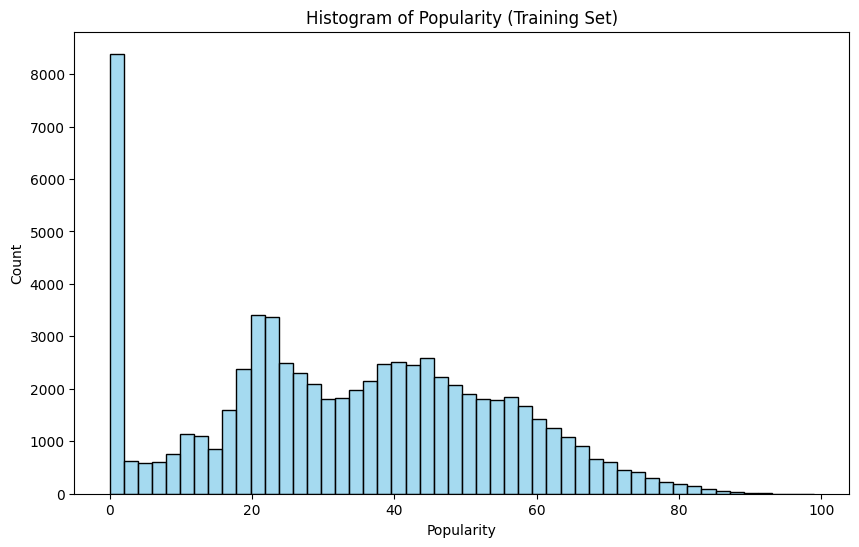

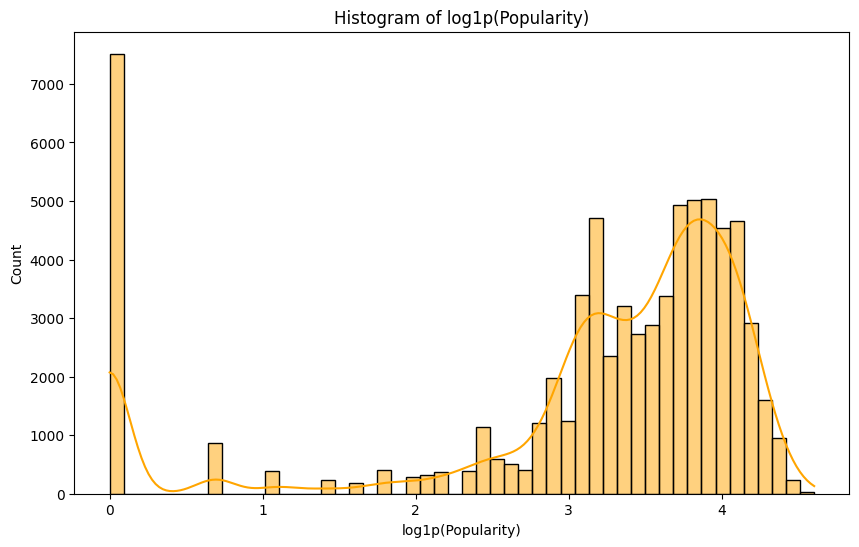

Total samples: 70612
Zero values: 7515
Positive values: 63097
Mean: 33.293491191298926
Median: 33.0
Std dev: 20.653504213206304
Min: 0
25% Quantile: 19.0
50% Quantile: 33.0
75% Quantile: 49.0
Max: 99


In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# load data
y_train = pd.read_csv("data/step3_y_train.csv").iloc[:, 0]

plt.figure(figsize=(10,6))

# Histogramm
sns.histplot(y_train, bins=50, kde=False, color='skyblue')
plt.title("Histogram of Popularity (Training Set)")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(np.log1p(y_train), bins=50, kde=True, color='orange')
plt.title("Histogram of log1p(Popularity)")
plt.xlabel("log1p(Popularity)")
plt.ylabel("Count")
plt.show()

import pandas as pd
import numpy as np


y_train = pd.read_csv("data/step3_y_train.csv").iloc[:, 0]


num_total = len(y_train)
num_zero = np.sum(y_train == 0)
num_positive = np.sum(y_train > 0)
mean = np.mean(y_train)
median = np.median(y_train)
std = np.std(y_train)
_min = np.min(y_train)
_max = np.max(y_train)
q25 = np.percentile(y_train, 25)
q50 = np.percentile(y_train, 50)
q75 = np.percentile(y_train, 75)


print("Total samples:", num_total)
print("Zero values:", num_zero)
print("Positive values:", num_positive)
print("Mean:", mean)
print("Median:", median)
print("Std dev:", std)
print("Min:", _min)
print("25% Quantile:", q25)
print("50% Quantile:", q50)
print("75% Quantile:", q75)
print("Max:", _max)

In [60]:
# Define Polynomial Model Tree
class SklearnPolynomialModelTree:
    def __init__(self, max_depth=6, min_samples_leaf=7, degree=3):
        self.tree = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        self.leaf_models = {}
        self.degree = degree

    def fit(self, X, y):
        self.tree.fit(X, y)
        leaf_ids = self.tree.apply(X)
        for leaf_id in np.unique(leaf_ids):
            idx = np.where(leaf_ids == leaf_id)[0]
            if len(idx) > 1:  # nur wenn Blatt mehr als 1 Sample
                poly = PolynomialFeatures(degree=self.degree, include_bias=False)
                X_poly = poly.fit_transform(X.iloc[idx])
                lr = LinearRegression()
                lr.fit(X_poly, y.iloc[idx])
                self.leaf_models[leaf_id] = (lr, poly)

    def predict_vectorized(self, X):
        leaf_ids = self.tree.apply(X)
        preds = np.zeros(X.shape[0])
        for leaf_id, (lr, poly) in self.leaf_models.items():
            idx = np.where(leaf_ids == leaf_id)[0]
            if len(idx) > 0:
                X_poly = poly.transform(X.iloc[idx])
                preds[idx] = lr.predict(X_poly)
        return preds

# Train the model
model = SklearnPolynomialModelTree(max_depth=4, min_samples_leaf=7, degree=2)
model.fit(X_train, y_train)

# Predict on test set
preds = model.predict_vectorized(X_test)

# Evaluate
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("Test MSE:", mse)
print("Test R²:", r2)

# save predictions
#pd.DataFrame(preds, columns=["pred"]).to_csv("predictions_polynomial.csv", index=False)

Test MSE: 71814.04780081485
Test R²: -169.70948622807262


In [4]:
class StablePolynomialModelTree:
    def __init__(self, max_depth=5, min_samples_leaf=20, degree=2, ridge_alpha=0.5, min_samples_poly=50):
        self.tree = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        self.leaf_models = {}
        self.degree = degree
        self.ridge_alpha = ridge_alpha
        self.min_samples_poly = min_samples_poly

    def fit(self, X, y):
        self.tree.fit(X, y)
        leaf_ids = self.tree.apply(X)
        for leaf_id in np.unique(leaf_ids):
            idx = np.where(leaf_ids == leaf_id)[0]
            if len(idx) > 1:
                # Verwende PolynomialFeatures nur bei genügend Samples
                if len(idx) >= self.min_samples_poly and self.degree > 1:
                    poly = PolynomialFeatures(degree=self.degree, interaction_only=True, include_bias=False)
                    X_poly = poly.fit_transform(X.iloc[idx])
                    model = Ridge(alpha=self.ridge_alpha)
                    model.fit(X_poly, y.iloc[idx])
                    self.leaf_models[leaf_id] = (model, poly)
                else:
                    # Normale Ridge Regression
                    model = Ridge(alpha=self.ridge_alpha)
                    model.fit(X.iloc[idx], y.iloc[idx])
                    self.leaf_models[leaf_id] = (model, None)

    def predict_vectorized(self, X):
        leaf_ids = self.tree.apply(X)
        preds = np.zeros(X.shape[0])
        for leaf_id, (model, poly) in self.leaf_models.items():
            idx = np.where(leaf_ids == leaf_id)[0]
            if len(idx) > 0:
                if poly is not None:
                    X_poly = poly.transform(X.iloc[idx])
                    preds[idx] = model.predict(X_poly)
                else:
                    preds[idx] = model.predict(X.iloc[idx])
        return preds

# Train the model
model = StablePolynomialModelTree(max_depth=5, min_samples_leaf=20, degree=2, ridge_alpha=0.5, min_samples_poly=50)
model.fit(X_train, y_train)

# Predict on test set
preds = model.predict_vectorized(X_test)

# Evaluate
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("Test MSE:", mse)
print("Test R²:", r2)

Test MSE: 335.8540222189064
Test R²: 0.2016399390319472


In [10]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the data
X_train = pd.read_csv("data/step3_X_train_scaled.csv")
y_train = pd.read_csv("data/step3_y_train.csv").iloc[:, 0]
X_test = pd.read_csv("data/step3_X_test_scaled.csv")
y_test = pd.read_csv("data/step3_y_test.csv").iloc[:, 0]


# Log-transform target to reduce skew
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)


# Define custom Model Tree
class SklearnModelTree:
    def __init__(self, max_depth=8, min_samples_leaf=3):
        self.tree = DecisionTreeRegressor(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf
        )
        self.leaf_models = {}

    def fit(self, X, y):
        # Fit tree to find leaves
        self.tree.fit(X, y)
        leaf_ids = self.tree.apply(X)
        
        # Fit linear regression in each leaf
        for leaf_id in np.unique(leaf_ids):
            idx = np.where(leaf_ids == leaf_id)[0]
            if len(idx) > 1:  # at least 2 samples to fit linear regression
                lr = LinearRegression()
                lr.fit(X.iloc[idx], y.iloc[idx])
                self.leaf_models[leaf_id] = lr

    def predict_vectorized(self, X):
        leaf_ids = self.tree.apply(X)
        preds = np.zeros(X.shape[0])
        for leaf_id, lr in self.leaf_models.items():
            idx = np.where(leaf_ids == leaf_id)[0]
            if len(idx) > 0:
                preds[idx] = lr.predict(X.iloc[idx])
        return preds

# Train Model Tree on log-transformed target
model = SklearnModelTree(max_depth=8, min_samples_leaf=3)
model.fit(X_train, y_train_log)

# Predict
preds_log = model.predict_vectorized(X_test)

# Transform back and clip to realistic range
preds = np.clip(np.expm1(preds_log), 0, 100)

# Evaluate
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("Test MSE:", mse)
print("Test R²:", r2)

Test MSE: 467.93917790959887
Test R²: -0.11234026061998281
